# Troubled markets and volatility
### _Challenging financial models through an exploration on the crash of Argentina's ADRs_

[American Depositary Reciepts](https://www.investopedia.com/terms/a/adr.asp) (ADRs) are financial instruments that allow US investors to purchase stocks in foreign companies. Argentina has a number of companies listed in US exchanges through ADRs.  
In this notebook, we will explore the performance of these ADRs with a focus on the period from January to August 2019, where political uncertainty sent markets into turmoil: the country’s Merval stock index fell 48% in dollar terms in a single day, the second-largest one-day drop in any of the 94 markets tracked by Bloomberg since 1950<sup>[1]</sup>, causing a 20% devaluation of the Argentine peso and a sharp drop in bond prices.  
We will be looking at the end-of-day data of the Argentine ADRs, and their corresponding put and call options, to examine whether the daily log returns of stocks are distributed normally, a conclusion that follows from the standard model due to [Bachelier](en.wikipedia.org/wiki/Louis_Bachelier).

[1]: https://www.ft.com/content/29764546-c821-11e9-a1f4-3669401ba76f

In [11]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os

import numpy as np
import pandas as pd
import warnings
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter('ignore')
register_matplotlib_converters()

In [12]:
sns.set(rc={'figure.figsize': (12,8)})


## Data munging

In [13]:
data_dir = 'data/'

In [14]:
tickers = [
    'BMA', 'BFR', 'CEPU', 'CRESY', 'EDN', 'GGAL', 'SUPV', 'IRS',
    'IRCP', 'LOMA', 'NTL', 'MELI', 'PAM', 'PZE', 'TEO', 'TS', 'TX',
    'TGS', 'YPF'
]

dfs = [pd.read_csv(os.path.join(data_dir, ticker.lower() + '.csv')) for ticker in tickers]

adrs_df = pd.concat(dfs, axis=0, ignore_index=False)
adrs_df.to_csv(os.path.join(data_dir, 'adrs.csv'), index=False)

FileNotFoundError: [Errno 2] File b'data/bma.csv' does not exist: b'data/bma.csv'

Next we'll concatenate all options daily files into a csv.

In [8]:
dfs = []

for root, dirs, files in os.walk(data_dir):
    if root.endswith('daily'):
        for file in files:
            df = pd.read_csv(os.path.join(root, file))
            dfs.append(df)
            
adr_options = pd.concat(dfs, axis=0)
adr_options.to_csv(os.path.join(data_dir, 'adr_options.csv'), index=False)

ValueError: No objects to concatenate

## Exploration

We begin our exploration of the end-of-day (EOD) data for Argentina's ADRs.

In [9]:
adrs_df = pd.read_csv(os.path.join(data_dir, 'adrs.csv'), index_col='date', parse_dates=['date'])
adrs_df.index = pd.DatetimeIndex(adrs_df.index.date, name='date')
adrs_df.head()

,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,,
2006-03-27,BMA,23.05,23.05,22.23,22.89,1065200,15.524521,15.524521,14.972239,15.416759,1065200,0.0,1.0
2006-03-28,BMA,22.38,22.47,21.90,22.47,1556100,15.073266,15.133883,14.749979,15.133883,1556100,0.0,1.0
2006-03-29,BMA,22.84,23.14,22.05,22.10,641300,15.383083,15.585138,14.851006,14.884682,641300,0.0,1.0
2006-03-30,BMA,22.75,23.10,22.70,23.00,293600,15.322467,15.558197,15.288791,15.490846,293600,0.0,1.0
2006-03-31,BMA,22.93,22.93,22.35,22.83,113600,15.443700,15.443700,15.053061,15.376348,113600,0.0,1.0


The data is indexed by date, with the `symbol` column holding the ticker name, and columns for the `open` and `close` prices (the price of the symbol at the start/end of the market day) and the `high` and `low` prices seen for the symbol at that date.  
We'll begin plotting the [`adjusted close`](http://www.crsp.com/products/documentation/crsp-calculations) prices for each symbol (price adjusted for dividends payed and stock splits). The reset of the columns can be safely ingored for our purposes.

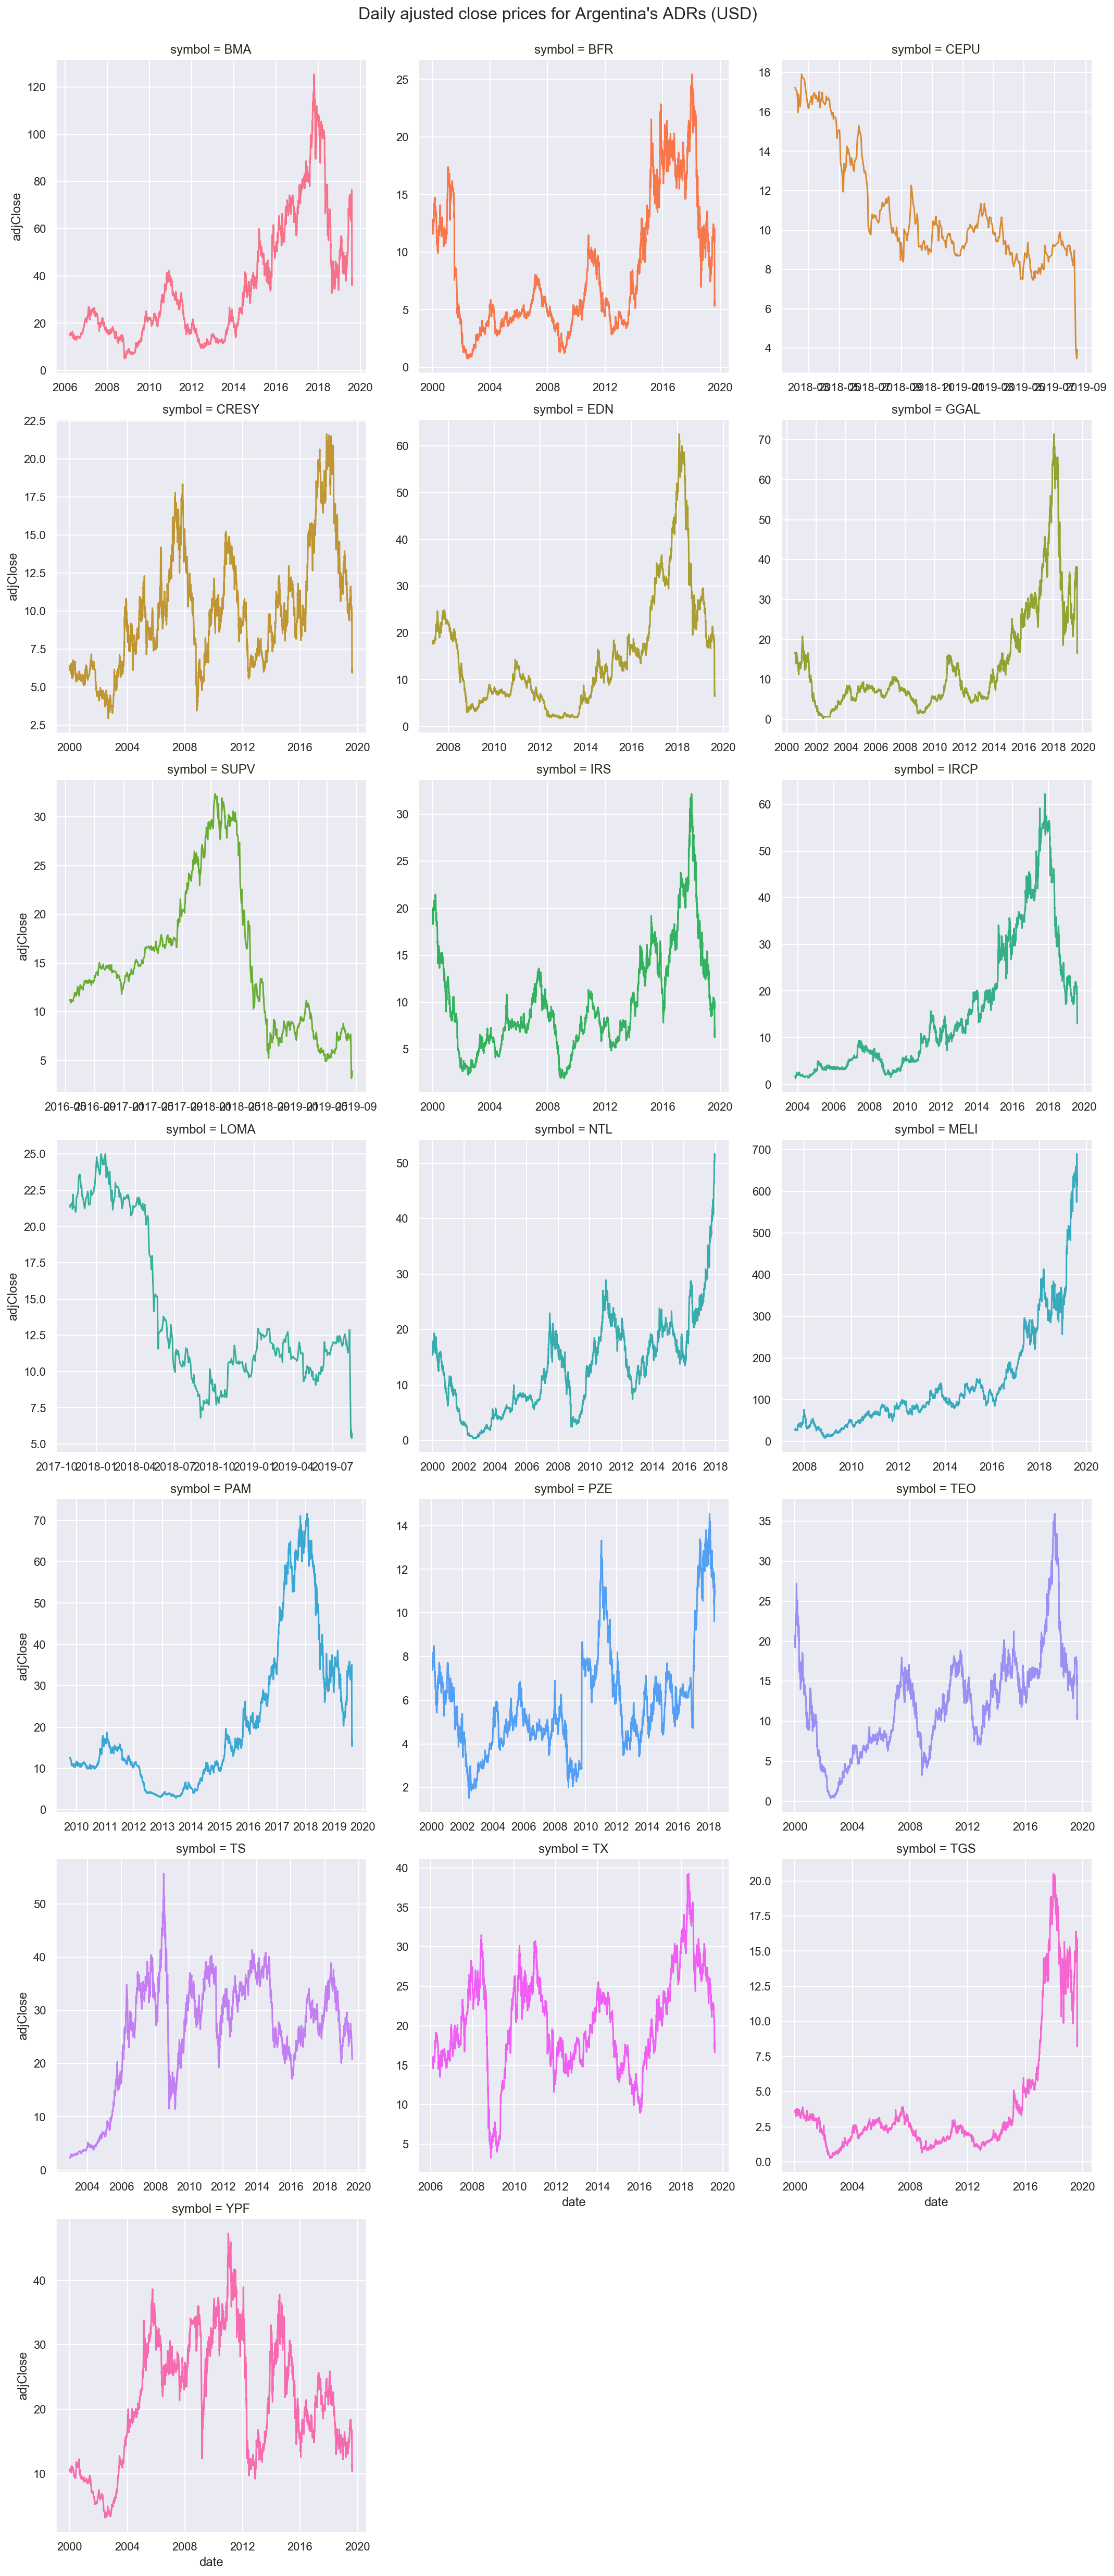

In [10]:
g = sns.relplot(x='date', y='adjClose', col='symbol', hue='symbol',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=False,
            kind='line', data=adrs_df.reset_index())

g.fig.suptitle("Daily ajusted close prices for Argentina's ADRs (USD)", size=16)
g.fig.subplots_adjust(top=.96);

Let's zoom in on the 2019 adjusted close prices.

In [ ]:
adrs_2019 = adrs_df.loc['2019']

g = sns.relplot(x='date', y='adjClose', col='symbol', hue='symbol',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=False,
            kind='line', data=adrs_2019.reset_index())

g.fig.suptitle("Daily ajusted close prices for Argentina's ADRs (USD) in 2019", size=16)
g.fig.subplots_adjust(top=.96);

We can see most stocks experienced a sharp decline in August 2019, after a surprise result of the presidential primaries caused a market crash. We also see that \\$MELI (MercadoLibre) is less vulnerable to the volatility in the Argentine market because it operates in over a dozen countries in Latin America.

In [ ]:
adrs_df.groupby('symbol')['adjClose'].describe()

### Simple returns

Next we'll calculate the daily _simple returns_.  

$$R_t \equiv \frac{S_t - S_{t-1}}{S_{t-1}}  \%$$

In [ ]:
adrs_df['return'] = adrs_df.groupby('symbol')['adjClose'].pct_change() * 100
adrs_df.head()

In [ ]:
adrs_df.groupby('symbol')['return'].describe()

Let's plot a histogram of the daily returns for each symbol.

In [ ]:
g = sns.FacetGrid(adrs_df, col='symbol', col_wrap=5, hue='symbol', sharey=False, sharex=False)
g.map(plt.hist, 'return', bins=25, density=True)

g.fig.suptitle('Histogram of daily returns', size=16)
g.fig.subplots_adjust(top=.93);

We see most returns cluster around 0, with a few outliers. Since we are interested particularly in the outliers, to see their quantity and magnitude, we can visualize them using a [boxenplot](https://vita.had.co.nz/papers/letter-value-plot.html).

In [ ]:
# Workaround to suppress matplotlib errors
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [ ]:
sns.boxenplot(y='symbol', x='return', data=adrs_df, scale='area',
              orient='h').set_title('Daily returns per symbol', size=16);

We can filter the days with 30% or larger movement in prices (either up or down).

In [ ]:
large_movements = adrs_df.loc[adrs_df['return'].abs() >= 30]
sns.scatterplot(x=large_movements.index,
                y='return',
                hue='symbol',
                data=large_movements).set_title(
                    'Large daily returns (+/- 30%)', size=16);

Now if we remove outliers, say discard days where return was higher than 10% or lower than -10%:

In [ ]:
g = sns.FacetGrid(adrs_df, col='symbol', col_wrap=5, hue='symbol', sharex=False)
g.map(plt.hist, 'return', bins=25, density=True, range=(-10,10))

g.fig.suptitle('Histogram of daily returns (between -10% / +10%)', size=16)
g.fig.subplots_adjust(top=.93);

### Log returns

In finance, it is common to look at the _log returns_ of an asset. They are defined as follows:

$$r_t \equiv \ln{\frac{S_t}{S_{t-1}}} = \ln{S_t} - \ln{S_{t-1}}$$

There is an equivalence between simple and log returns:

\begin{align}
r_t &= \ln{(R_t + 1)} \\
R_t &= \exp{r_t} - 1
\end{align}

You can find further information on the two return types in this [post](https://www.portfolioprobe.com/2010/10/04/a-tale-of-two-returns/).

Stock prices are assumed to follow a [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution, hence we should expect log returns to be distributed [normally](https://en.wikipedia.org/wiki/Normal_distribution).

$$ln(S_T)\sim N\big[ln(S_0)+(\mu-\frac{\sigma^2}{2})T,\;\sigma^2T\big] \\
ln(\frac{S_T}{S_0})\sim N\big[(\mu-\frac{\sigma^2}{2})T, \;\sigma^2T\big]$$

Where $S_T$ is the price of the underlying at time $T$.  
For a more detailed discussion on the assumptions of the [Black-Scholes-Merton](https://en.wikipedia.org/wiki/Black–Scholes_model) model, see chapter 15 of _Options, Futures and Other Derivatives_ (9th Ed) by John Hull.  
You can read more on the distribution of prices and returns [here](https://www.investopedia.com/articles/investing/102014/lognormal-and-normal-distribution.asp).

In [ ]:
adrs_df['log_return'] = np.log(adrs_df['return'] / 100 + 1.)

Now we can calculate the [volatility](https://en.wikipedia.org/wiki/Volatility_(finance)) $\sigma$ for each symbol, defined as the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) of log returns.  
As a comparison, we'll add the daily volatility (from 2000 to 2019) for four of the so called [blue chip stocks](https://www.investopedia.com/terms/b/bluechipstock.asp), Coca-Cola (\\$KO), Goldman Sachs (\\$GS), IBM (\\$IBM) and Walmart (\\$WMT).

In [ ]:
blue_chip = pd.read_csv(os.path.join(data_dir, 'blue_chip.csv'),
                        index_col=['date', 'symbol'],
                        parse_dates=['date'])
blue_chip['log_return'] = blue_chip.groupby('symbol')['adjClose'].apply(
    lambda x: np.log(x) - np.log(x.shift(1)))

In [ ]:
adr_volatility = adrs_df.groupby('symbol')['log_return'].std()
adr_volatility = adr_volatility.append(blue_chip.groupby('symbol')['log_return'].std())

sns.barplot(x=adr_volatility.index, y=adr_volatility.values).set_title(
    'Daily volatility $\sigma_{daily}$ for each symbol (std of log returns)',
    size=16);

We can see that Argentine stocks show much higher volatility than the blue chip stocks.

Let's plot the mean yearly returns for each symbol. Again, we'll add the mean daily return of the US blue chips.

In [ ]:
yearly_rets = np.exp(
    adrs_df.groupby('symbol')['log_return'].resample('Y',
                                                     label='right').sum()) - 1
yearly_rets = yearly_rets.reset_index()
yearly_rets['return %'] = yearly_rets['log_return'] * 100

blue_chip.reset_index(level='symbol', inplace=True)
blue_chip_rets = np.exp(
    blue_chip.groupby('symbol')['log_return'].resample(
        'Y', label='right').sum()) - 1
blue_chip_rets = blue_chip_rets.reset_index()
blue_chip_rets['return %'] = blue_chip_rets['log_return'] * 100

In [ ]:
mean_rets = yearly_rets.groupby('symbol')['return %'].mean()
mean_rets = mean_rets.append(blue_chip_rets.groupby('symbol')['return %'].mean())
sns.barplot(x=mean_rets.index, y=mean_rets.values).set_title(
    "Mean yearly returns of Argentina's ADRs", size=16);

As expected, besides increased volatility, Argentine stocks, for the most part, exhibit higher yearly returns than the chosen US stocks.

### A closer look at outliers

Let's plot the returns that are at least $3\sigma$ away from the mean. If log returns were truly distributed normally, then we should expect this group to represent only $0.3\%$ of the data, while the remaining $99.7\%$ should lie in the interval $(\mu_r - 3\sigma_r, \mu_r + 3\sigma_r)$.

In [ ]:
def outlier_filter(symbol_df):
    symbol = symbol_df['symbol'].iloc[0]
    return symbol_df.loc[(symbol_df['log_return'] -
                          symbol_df['log_return'].mean()).abs() >= 3 *
                         adr_volatility[symbol]]

outliers = adrs_df.groupby('symbol').apply(outlier_filter).reset_index(
    level=0, drop=True)

In [ ]:
sns.scatterplot(x=outliers.index, y='log_return', hue='symbol',
                data=outliers).set_title('$3\sigma$ outlier daily returns',
                                         size=16);

We see a large number of outlier return days. To put that in perspective, let's calculate the proportion of outlier returns for each symbol in the data, that is the number of days where $3\sigma$ returns where observed over the total number of observations.

In [ ]:
outlier_count = outliers.groupby('symbol')['log_return'].count()
ret_count = adrs_df.groupby('symbol')['log_return'].count()

outlier_pct = 100 * outlier_count / ret_count
ax = sns.barplot(x=outlier_pct.index, y=outlier_pct.values)
ax.axhline(0.3, alpha=0.6, linestyle='--', color='r', label='expected % of outliers')
ax.legend()
ax.set_title(
    'Outlier proportion (outlier daily return count / total daily returns)',
    size=16);

We see many more outliers than the expected $0.3\%$. For example, \$MELI has almost 7 times more outlier return days than expected if we assumed normal log returns.

Finally, we'll look at the cumulative log returns over time.

In [ ]:
pivoted = adrs_df.pivot(columns='symbol', values='log_return')
pivoted.cumsum().apply(np.exp).plot(title='Cumulative log returns', colormap='Set1');

If you had invested in \\$MELI's IPO in 2007, you've had have over 25 times your initial investment by August 2019. You would also have to stomach losing close to 60% at the end of 2008.

### ADR options and the volatility smile

We've observed ADRs experienced a very high volatility, and this leads us to question wether the prices of financial derivatives such as options were affected.

We will explore how volatility in the prices of the underlying assests impacted option prices during the crash.

To this end, we will examine the options end-of-day data for the ADRs. [Options](https://www.investopedia.com/terms/o/option.asp) are derivative contracts based on an underlying asset such as stocks. They offer the buyer the opportunity to buy or sell the underlying asset at a given price (or _strike price_ ). You can find more information on options in [this notebook](../intro-finance.ipynb).



In [ ]:
adr_options = pd.read_csv(os.path.join(data_dir, 'adr_options.csv'),
                          index_col='quotedate',
                          parse_dates=['quotedate', 'expiration'])
adr_options.head()

The options data is also indexed by date. These are the most important columns:
- `underlying`: The ticker of the underlying asset.
- `underlying_last`: The last quoted price of the underlying asset.
- `optionroot`: The name of the contract.
- `type`: Contract type (_put_ or _call_)
- `strike`: The price at which owner can execute (buy/sell underlying).
- `expiration`: Date of expiration of the option.
- `bid`: The price at which investor can _sell_ this contract.
- `ask`: The price at which investor can _buy_ this contract.
- `openinterest`: The total number of contract outstanding.
- `impliedvol`: Volatility of the underlying as implied by the option price (according to BSM model)

Let's plot the [volatility smile](https://www.investopedia.com/terms/v/volatilitysmile.asp) for each symbol at 2019-08-09, the Friday before the primaries.  
The volatility smile plots the [implied volatility](https://www.investopedia.com/terms/i/iv.asp) (IV, a measure of the volatility of an underlying security as _implied_ by the option prices) at the different strike levels.  
We'll plot the IV for puts and calls for each symbol. The dashed line represents the spot price.

In [ ]:
friday_9th = adr_options.loc['2019-08-9']

# Keep puts with K <= spot and calls with K > spot
friday_9th = friday_9th.query(
    '((type == "put") & (strike <= underlying_last)) | ((type == "call") & (strike > underlying_last))'
)

g = sns.relplot(x='strike', y='impliedvol', col='underlying',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3,
            kind='line', data=friday_9th, ci=None, color='coral')

for ax, symbol in zip(g.axes, g.col_names):
    spot_price = friday_9th.loc[friday_9th['underlying'] == symbol, 'underlying_last'].iloc[0]
    ax.axvline(spot_price, alpha=0.4, linestyle='--')
    
g.fig.suptitle('Volatility smiles - August 9th 2019', size=16)
g.fig.subplots_adjust(top=.94);

We see that as options move more [at the money](https://www.investopedia.com/terms/a/atthemoney.asp) (ATM) their implied volatility drops. In contrast, options that are further [out of the money](https://www.investopedia.com/terms/o/outofthemoney.asp) (OTM) or in the money (ITM) have higher IVs.

Now let's try the same plot for the following Monday (2019-08-12). That day, the [MERVAL](https://en.wikipedia.org/wiki/MERVAL) (an index that tracks the biggest companies listed in the Buenos Aires Stock Exchange) crashed and lost close to 50% of its USD value.

In [ ]:
black_monday = adr_options.loc['2019-08-12']

# Keep puts with K <= spot and calls with K > spot
black_monday = black_monday.query(
    '((type == "put") & (strike <= underlying_last)) | ((type == "call") & (strike > underlying_last))'
)

g = sns.relplot(x='strike', y='impliedvol', col='underlying',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3,
            kind='line', data=black_monday, ci=None, color='coral')

for ax, symbol in zip(g.axes, g.col_names):
    spot_price = black_monday.loc[black_monday['underlying'] == symbol, 'underlying_last'].iloc[0]
    ax.axvline(spot_price, alpha=0.4, linestyle='--')
    
g.fig.suptitle('Volatility smiles - August 12th 2019', size=16)
g.fig.subplots_adjust(top=.94);

As stock prices droped sharply, we find less put contracts were being offered. Again, we see IV getting higher as the strike priced moves away from the spot price.

### Option price evolution

Next, we'll analyze how option prices changed during the month of August, 2019.
Let's find the 10 most actively traded options (those with the highest open interest) for each symbol at the start of the month.

In [ ]:
august_options = adr_options.loc['2019-08']

In [ ]:
def filter_active(symbol_df, option_type='call'):
    return symbol_df.loc[symbol_df['type'] == option_type].nlargest(
        n=10, columns='openinterest')

month_start_date = august_options.index.min()
first_trading_day = august_options.loc[month_start_date]
most_active_calls = first_trading_day.groupby('underlying').apply(
    filter_active).reset_index(level=0, drop=True)
most_active_puts = first_trading_day.groupby('underlying').apply(
    lambda df: filter_active(df, 'put')).reset_index(level=0, drop=True)

In [ ]:
call_contracts = most_active_calls['optionroot']
put_contracts = most_active_puts['optionroot']

In [ ]:
august_active_calls = august_options.loc[august_options['optionroot'].isin(call_contracts)]
august_active_puts = august_options.loc[august_options['optionroot'].isin(put_contracts)]

august_active_calls['day'] = august_active_calls.index.strftime('%d')
august_active_puts['day'] = august_active_puts.index.strftime('%d')

#### August 2019

We'll plot the evolution of the ask price for the actively traded calls through August 2019.

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=august_active_calls, ci=None)

g.fig.suptitle('Ask price for most actively traded calls in August 2019', size=16)
g.fig.subplots_adjust(top=0.94);

Note that the \\$BFR plot shows all calls with an `ask` price of 0.0. In June 2019, Banco Frances SA [announced](https://finance.yahoo.com/news/bbva-banco-franc-change-ticker-165400264.html) it would  change its ticker symbol from \\$BFR to \\$BBAR. We will update the plots when we get the correct data for the missing months.

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=august_active_puts, ci=None)

g.fig.suptitle('Ask price for most actively traded puts in August 2019', size=16)
g.fig.subplots_adjust(top=0.94);

This plots reveal a huge drop in prices for the calls, and, conversely, a large increase in the price of puts, between Friday 9th and Monday 12th.

#### June 2019

As a comparison, let's try plotting the option prices for June 2019, a more uneventful month for the Argentine market.

In [ ]:
june_options = adr_options.loc['2019-06']

In [ ]:
month_start_date = june_options.index.min()
first_trading_day = june_options.loc[month_start_date]
most_active_calls = first_trading_day.groupby('underlying').apply(
    filter_active).reset_index(level=0, drop=True)
most_active_puts = first_trading_day.groupby('underlying').apply(
    lambda df: filter_active(df, 'put')).reset_index(level=0, drop=True)

In [ ]:
call_contracts = most_active_calls['optionroot']
put_contracts = most_active_puts['optionroot']

In [ ]:
june_active_calls = june_options.loc[june_options['optionroot'].isin(call_contracts)]
june_active_puts = june_options.loc[june_options['optionroot'].isin(put_contracts)]

june_active_calls['day'] = june_active_calls.index.strftime('%d')
june_active_puts['day'] = june_active_puts.index.strftime('%d')

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=june_active_calls, ci=None)

g.fig.suptitle('Ask price for most actively traded calls in June 2019', size=16)
g.fig.subplots_adjust(top=0.94);

Next we'll have a look the the actively traded puts for June 2019.

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=june_active_puts, ci=None)

g.fig.suptitle('Ask price for most actively traded puts in June 2019', size=16)
g.fig.subplots_adjust(top=0.94);

#### October 2015

Let's have a look at the options data from October, November and December 2015.  
During those months, the Argentine elections took place, which marked the beginning of a bull market. In the following four years, the MERVAL index increased four-fold its value in Pesos.

In [ ]:
october_2015_options = pd.read_csv(os.path.join(data_dir, 'adr_options_October_2015.csv'),
                                   index_col='quotedate',
                                   parse_dates=['quotedate', 'expiration'])

In [ ]:
month_start_date = october_2015_options.index.min()
first_trading_day = october_2015_options.loc[month_start_date]
most_active_calls = first_trading_day.groupby('underlying').apply(
    filter_active).reset_index(level=0, drop=True)
most_active_puts = first_trading_day.groupby('underlying').apply(
    lambda df: filter_active(df, 'put')).reset_index(level=0, drop=True)

In [ ]:
call_contracts = most_active_calls['optionroot']
put_contracts = most_active_puts['optionroot']

In [ ]:
october2015_active_calls = october_2015_options.loc[october_2015_options['optionroot'].isin(call_contracts)]
october2015_active_puts = october_2015_options.loc[october_2015_options['optionroot'].isin(put_contracts)]

october2015_active_calls['day'] = october2015_active_calls.index.strftime('%d')
october2015_active_puts['day'] = october2015_active_puts.index.strftime('%d')

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=october2015_active_calls, ci=None)

g.fig.suptitle('Ask price for most actively traded calls in October 2015', size=16)
g.fig.subplots_adjust(top=0.94);

Now let's plot the actively traded puts for October 2015

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=october2015_active_puts, ci=None)

g.fig.suptitle('Ask price for most actively traded puts in October 2015', size=16)
g.fig.subplots_adjust(top=0.94);

#### November 2015

In [ ]:
november_2015_options = pd.read_csv(os.path.join(data_dir, 'adr_options_november_2015.csv'),
                                   index_col='quotedate',
                                   parse_dates=['quotedate', 'expiration'])

In [ ]:
month_start_date = november_2015_options.index.min()
first_trading_day = november_2015_options.loc[month_start_date]
most_active_calls = first_trading_day.groupby('underlying').apply(
    filter_active).reset_index(level=0, drop=True)
most_active_puts = first_trading_day.groupby('underlying').apply(
    lambda df: filter_active(df, 'put')).reset_index(level=0, drop=True)

In [ ]:
call_contracts = most_active_calls['optionroot']
put_contracts = most_active_puts['optionroot']

In [ ]:
november2015_active_calls = november_2015_options.loc[november_2015_options['optionroot'].isin(call_contracts)]
november2015_active_puts = november_2015_options.loc[november_2015_options['optionroot'].isin(put_contracts)]

november2015_active_calls['day'] = november2015_active_calls.index.strftime('%d')
november2015_active_puts['day'] = november2015_active_puts.index.strftime('%d')

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=october2015_active_calls, ci=None)

g.fig.suptitle('Ask price for most actively traded calls in November 2015', size=16)
g.fig.subplots_adjust(top=0.94);

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=october2015_active_puts, ci=None)

g.fig.suptitle('Ask price for most actively traded puts in November 2015', size=16)
g.fig.subplots_adjust(top=0.94);

#### December 2015

In [ ]:
december_2015_options = pd.read_csv(os.path.join(data_dir, 'adr_options_December_2015.csv'),
                                   index_col='quotedate',
                                   parse_dates=['quotedate', 'expiration'])

In [ ]:
month_start_date = december_2015_options.index.min()
first_trading_day = december_2015_options.loc[month_start_date]
most_active_calls = first_trading_day.groupby('underlying').apply(
    filter_active).reset_index(level=0, drop=True)
most_active_puts = first_trading_day.groupby('underlying').apply(
    lambda df: filter_active(df, 'put')).reset_index(level=0, drop=True)

In [ ]:
call_contracts = most_active_calls['optionroot']
put_contracts = most_active_puts['optionroot']

In [ ]:
december2015_active_calls = december_2015_options.loc[december_2015_options['optionroot'].isin(call_contracts)]
december2015_active_puts = december_2015_options.loc[december_2015_options['optionroot'].isin(put_contracts)]

december2015_active_calls['day'] = december2015_active_calls.index.strftime('%d')
december2015_active_puts['day'] = december2015_active_puts.index.strftime('%d')

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=october2015_active_calls, ci=None)

g.fig.suptitle('Ask price for most actively traded calls in December 2015', size=16)
g.fig.subplots_adjust(top=0.94);

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=october2015_active_puts, ci=None)

g.fig.suptitle('Ask price for most actively traded puts in December 2015', size=16)
g.fig.subplots_adjust(top=0.94);

#### January 2008

We'll examine the Argentine ADR options data for January 2008, the beginning of the US mortgage crisis, which had global effects. We only have data for 3 companies: \\$MELI, \\$TS and \\$TX

In [ ]:
january_2008_options = pd.read_csv(os.path.join(data_dir, 'adr_options_january_2008.csv'),
                                   index_col='quotedate',
                                   parse_dates=['quotedate', 'expiration'])

In [ ]:
month_start_date = january_2008_options.index.min()
first_trading_day = january_2008_options.loc[month_start_date]
most_active_calls = first_trading_day.groupby('underlying').apply(
    filter_active).reset_index(level=0, drop=True)
most_active_puts = first_trading_day.groupby('underlying').apply(
    lambda df: filter_active(df, 'put')).reset_index(level=0, drop=True)

In [ ]:
call_contracts = most_active_calls['optionroot']
put_contracts = most_active_puts['optionroot']

In [ ]:
january2008_active_calls = january_2008_options.loc[january_2008_options['optionroot'].isin(call_contracts)]
january2008_active_puts = january_2008_options.loc[january_2008_options['optionroot'].isin(put_contracts)]

january2008_active_calls['day'] = january2008_active_calls.index.strftime('%d')
january2008_active_puts['day'] = january2008_active_puts.index.strftime('%d')

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=january2008_active_calls, ci=None)

g.fig.suptitle('Ask price for most actively traded calls in January 2008', size=16)
g.fig.subplots_adjust(top=0.88);

In [ ]:
g = sns.relplot(x='day', y='ask', col='underlying', hue='optionroot',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=None,
            kind='line', data=january2008_active_puts, ci=None)

g.fig.suptitle('Ask price for most actively traded puts in January 2008', size=16)
g.fig.subplots_adjust(top=0.88);

As the market went bearish, calls decreased in value and puts became more expensive.

## Final notes

Countries such as Argentina exhibit high [political beta](https://www.fa-mag.com/news/political-beta-44530.html): stocks show extreme sensitivity to political events. The MERVAL index nearly quadrupled its value in Pesos since December 2015, only to drop by 40% in a single day in August 2019.  
Investors tend to exacerbate bull runs, discounting future growth in the current stock prices. At the prospect of regulatory changes and political turnover, they panic sell and seek less risky assets. There remains to be seen whether savvy traders can exploit both the overconfident bulls and the panicking bears, buying volatility from the former to sell it at a profit to the latter.